# Multi-class classifier: MNIST images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/6.multiclass-classifier-mnist.ipynb)

By [Terence Parr](https://explained.ai).

To demonstrate $k$ class classification instead of binary ($k=2$) classification, let's use the traditional MNIST digital image recognition problem. We'll again use a random forest model as a baseline classifier. Instead of a sigmoid on a single output neuron, $k$ class classifiers use $k$ neurons in the final layer and then a softmax computation instead of a single-output sigmoid. We see fairly decent recognition results with just 50 neurons. By using 1000 neurons, we get slightly better results. To demonstrate cyclic learning rates, which sometimes helps to find more general solutions, there's a final model using pytorch's CyclicLR learning rate scheduler.

In [53]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [54]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

Let's use a subset of the well-known MNIST handwritten digits data set. This problem is the "hello world" of image recognition for deep learning.  The images have 28x28 pixels for a total of 784 features if we flatten them into feature vectors. Each row in the data set will represent an image.

In [55]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [56]:
X.shape # There are 784 pixels per 28x28 image

(10000, 784)

In [57]:
# shuffle so that images for the digits are not grouped together
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

Using the handy function from above, let's display a sample of the images and their true known values. As you can see, there's a great deal of variety in how different people draw Hindu-Arabic numerals.

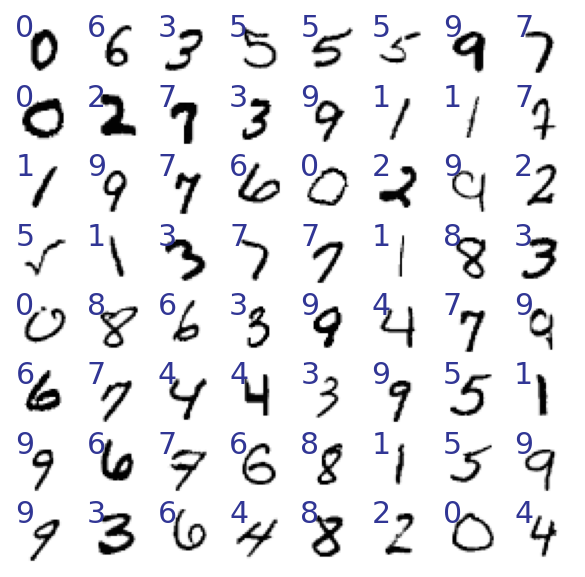

In [58]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

In order to measure the generality of our model, which is what we really care about, let's split the images 80/20 into training/validation sets:

In [59]:
X = torch.tensor(X).float()
y = torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random forest baseline

It's also a good idea to get a baseline performance so that we know whether all of this neural network stuff is worth the hassle. In other words, if a random forest, which is easy to use and train, is good enough then we don't need the complexity of a neural network. Let's train a random forest classifier with a lot of trees. (`n_jobs=-1` just tells the scikit-learn library to compute the trees in parallel across multiple core.)

In [65]:
rf = RandomForestClassifier(n_estimators=900, n_jobs=-1)
rf.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=900, n_jobs=-1)

Let's compute the accuracy of the model on both the training and validation sets:

In [66]:
y_train_accuracy = rf.score(X_train, y_train)
y_accuracy = rf.score(X_test, y_test)
y_train_accuracy, y_accuracy

(1.0, 0.977)

The classifier gets 100% accuracy on the 8000 images of the training set and 97.5% accuracy on the validation set. That's pretty good considering we didn't have to think much to get the classifier to work.

To get more detail, let's look at the *confusion matrix* whose $(i,j)$ elements represent the count of records (images) known to be class $i$ but predicted to be in class $j$.  In this case, the column and row headers are the digits 0..9. The sklearn function `confusion_matrix` takes the true $y$ and compares it to the predicted $\hat{y}$ to yield a matrix:

In [76]:
y_pred = rf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
print(conf)

[[181   0   2   1   0   0   0   0   1   0]
 [  0 249   0   0   0   0   0   0   0   0]
 [  0   0 192   1   4   1   0   0   4   1]
 [  0   0   1 187   0   0   0   0   0   0]
 [  0   1   0   0 192   0   0   0   2   6]
 [  1   0   0   0   0 195   0   0   1   1]
 [  0   0   0   0   0   0 178   0   0   0]
 [  0   1   1   0   1   0   0 225   1   3]
 [  1   0   0   2   0   1   0   0 191   1]
 [  0   0   0   3   2   0   0   1   0 164]]


The correct predictions lie on the diagonal when $i=j$ because we have predicted the true value. Without labels that's a little bit harder to interpret so let's thrown into a data frame:

In [109]:
def showmatrix(conf):
    df_conf = pd.DataFrame(conf,
                       index=[f"$y$={i}" for i in range(0,9+1)],
                       columns=["$\hat{y}$="+str(i) for i in range(0,9+1)])
    return df_conf

In [110]:
showmatrix(conf)

,$\hat{y}$=0,$\hat{y}$=1,$\hat{y}$=2,$\hat{y}$=3,$\hat{y}$=4,$\hat{y}$=5,$\hat{y}$=6,$\hat{y}$=7,$\hat{y}$=8,$\hat{y}$=9
$y$=0,181,0,2,1,0,0,0,0,1,0
$y$=1,0,249,0,0,0,0,0,0,0,0
$y$=2,0,0,192,1,4,1,0,0,4,1
$y$=3,0,0,1,187,0,0,0,0,0,0
$y$=4,0,1,0,0,192,0,0,0,2,6
$y$=5,1,0,0,0,0,195,0,0,1,1
$y$=6,0,0,0,0,0,0,178,0,0,0
$y$=7,0,1,1,0,1,0,0,225,1,3
$y$=8,1,0,0,2,0,1,0,0,191,1
$y$=9,0,0,0,3,2,0,0,1,0,164


Ok, now let's see how well a neural network does.

## Vanilla one hidden layer of 50 neurons, softmax on end

In [111]:
def ctrain0(model, X, y, learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:5d} cross entropy loss {loss:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")

In [112]:
model = nn.Sequential(
    nn.Linear(784, 50), # 50 neurons
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [113]:
ctrain0(model, X_train, y_train, learning_rate = .03, nepochs=1000)

Epoch     0 cross entropy loss  2.3016
Epoch   100 cross entropy loss  1.4902
Epoch   200 cross entropy loss  1.4840
Epoch   300 cross entropy loss  1.4820
Epoch   400 cross entropy loss  1.4806
Epoch   500 cross entropy loss  1.4791
Epoch   600 cross entropy loss  1.4780
Epoch   700 cross entropy loss  1.4780
Epoch   800 cross entropy loss  1.4777
Epoch   900 cross entropy loss  1.4777
Epoch  1000 cross entropy loss  1.4774
LAST        cross entropy loss  1.4774


In [121]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.983


In [132]:
print(f"TRAINING CONFUSION MATRIX {train_accur*100:.1f}%")
conf = confusion_matrix(y_train, y_pred)
showmatrix(conf)

TRAINING CONFUSION MATRIX 98.3%


,$\hat{y}$=0,$\hat{y}$=1,$\hat{y}$=2,$\hat{y}$=3,$\hat{y}$=4,$\hat{y}$=5,$\hat{y}$=6,$\hat{y}$=7,$\hat{y}$=8,$\hat{y}$=9
$y$=0,783,0,0,0,0,2,1,0,1,0
$y$=1,0,868,4,2,1,0,2,1,1,0
$y$=2,0,1,769,1,1,0,9,5,6,0
$y$=3,2,0,0,789,0,6,0,0,10,6
$y$=4,0,0,0,0,786,0,0,2,3,1
$y$=5,1,0,1,1,1,725,6,0,0,3
$y$=6,2,0,3,0,0,1,766,0,2,0
$y$=7,0,2,5,0,4,0,0,857,1,1
$y$=8,3,0,1,1,0,4,1,0,764,2
$y$=9,3,1,1,9,1,1,0,3,0,760


In [133]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.958


In [134]:
print(f"VALIDATION CONFUSION MATRIX {test_accur*100:.1f}%")
conf = confusion_matrix(y_test, y_test_pred)
showmatrix(conf)

VALIDATION CONFUSION MATRIX 95.8%


,$\hat{y}$=0,$\hat{y}$=1,$\hat{y}$=2,$\hat{y}$=3,$\hat{y}$=4,$\hat{y}$=5,$\hat{y}$=6,$\hat{y}$=7,$\hat{y}$=8,$\hat{y}$=9
$y$=0,178,0,1,3,0,1,1,1,0,0
$y$=1,0,244,1,1,0,0,2,0,1,0
$y$=2,1,0,185,3,4,0,2,2,6,0
$y$=3,0,0,0,180,1,2,0,0,3,2
$y$=4,0,1,0,0,193,0,0,1,1,5
$y$=5,2,0,1,3,2,188,1,0,1,0
$y$=6,0,0,0,0,0,0,178,0,0,0
$y$=7,0,2,0,3,0,0,0,222,1,4
$y$=8,2,0,2,3,0,2,0,0,186,1
$y$=9,0,0,0,3,2,1,0,2,0,162


## Track validation versus training loss

As we did before in a previous notebook, it often helps if we track the validation error has training proceeds so we can see how it diverges from the training error. Here's an improved training method:

In [18]:
def ctrain1(model, X_train, y_train, X_test, y_test, 
            learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [19]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [20]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = .03, nepochs=1000)

Epoch    0 cross entropy loss  2.3017   test loss  2.3018
Epoch  100 cross entropy loss  1.4903   test loss  1.5076
Epoch  200 cross entropy loss  1.4843   test loss  1.5023
Epoch  300 cross entropy loss  1.4827   test loss  1.5007
Epoch  400 cross entropy loss  1.4802   test loss  1.4990
Epoch  500 cross entropy loss  1.4787   test loss  1.4990
Epoch  600 cross entropy loss  1.4780   test loss  1.4984
Epoch  700 cross entropy loss  1.4779   test loss  1.4982
Epoch  800 cross entropy loss  1.4778   test loss  1.4982
Epoch  900 cross entropy loss  1.4778   test loss  1.4980
Epoch 1000 cross entropy loss  1.4772   test loss  1.4960
LAST        cross entropy loss  1.4772


In [21]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.984


In [22]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.965


Now that we have a complete history, we can plot the error trajectories:

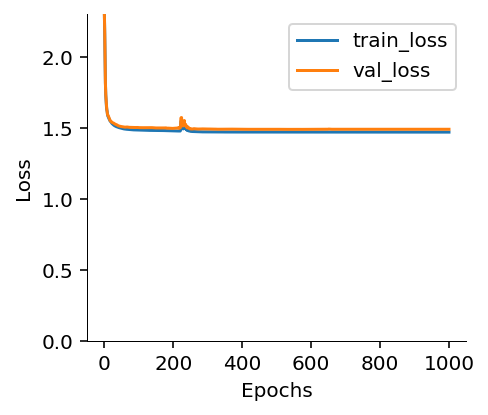

In [135]:
plot_loss(history)

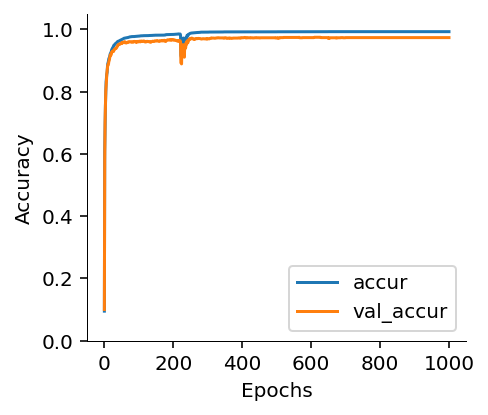

In [136]:
plot_accur(history)

The good news is that the error curves do not seem to diverge and so our model does not seem to be overfit. On the other hand, our neural network does not perform above the random forest baseline so let's crank up the number of neurons and see what happens.

## Using more neurons improve accuracy

In [161]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [166]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = 0.02, nepochs=1000)

Epoch    0 cross entropy loss  1.4774   test loss  1.5000
Epoch  100 cross entropy loss  1.4760   test loss  1.4973
Epoch  200 cross entropy loss  1.4748   test loss  1.4968
Epoch  300 cross entropy loss  1.4748   test loss  1.4982
Epoch  400 cross entropy loss  1.4745   test loss  1.4972
Epoch  500 cross entropy loss  1.4724   test loss  1.4956
Epoch  600 cross entropy loss  1.4724   test loss  1.4956
Epoch  700 cross entropy loss  1.4723   test loss  1.4956
Epoch  800 cross entropy loss  1.4723   test loss  1.4947
Epoch  900 cross entropy loss  1.4722   test loss  1.4939
Epoch 1000 cross entropy loss  1.4722   test loss  1.4943
LAST        cross entropy loss  1.4722


In [167]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.989


In [168]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.966


In [169]:
conf = confusion_matrix(y_test, y_test_pred.detach().numpy())
print(f"VALIDATION CONFUSION MATRIX {test_accur*100:.1f}%")
showmatrix(conf)

VALIDATION CONFUSION MATRIX 96.7%


,$\hat{y}$=0,$\hat{y}$=1,$\hat{y}$=2,$\hat{y}$=3,$\hat{y}$=4,$\hat{y}$=5,$\hat{y}$=6,$\hat{y}$=7,$\hat{y}$=8,$\hat{y}$=9
$y$=0,181,0,1,0,1,0,0,0,1,1
$y$=1,0,246,1,0,1,0,0,0,1,0
$y$=2,0,0,193,2,3,0,1,2,2,0
$y$=3,0,0,0,179,1,3,0,1,2,2
$y$=4,0,0,1,0,195,1,0,1,2,1
$y$=5,1,0,1,1,0,188,1,1,5,0
$y$=6,1,0,0,0,0,1,176,0,0,0
$y$=7,0,0,2,0,2,1,0,222,2,3
$y$=8,2,0,1,2,0,2,0,0,188,1
$y$=9,0,0,0,0,3,0,0,2,0,165


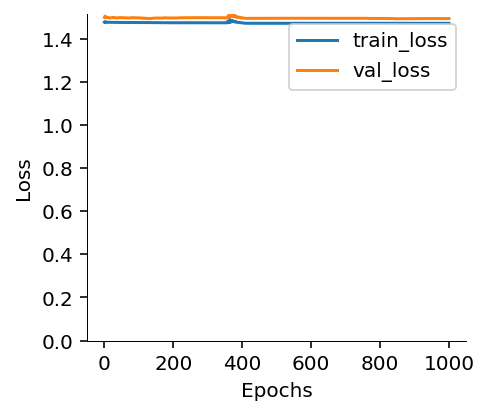

In [170]:
plot_loss(history)

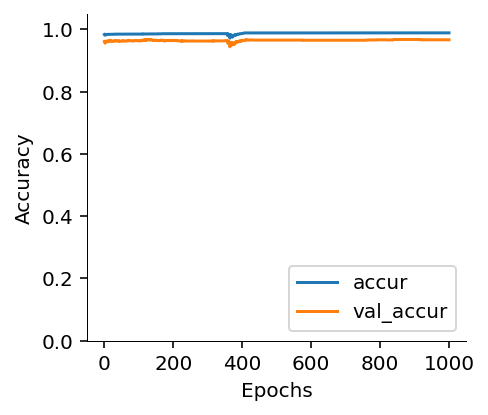

In [171]:
plot_accur(history)

## Training with cyclic learning rates

In [31]:
def ctrain2(model, X_train, y_train, X_test, y_test, 
            nepochs=2000,
            base_lr=0.01, max_lr=0.05):
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  mode='triangular2',
                                                  step_size_up=500,
                                                  base_lr=base_lr, max_lr=max_lr,
                                                  cycle_momentum=False)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}   LR {scheduler.get_last_lr()[0]:7.6f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
        scheduler.step()
        
    print(f"LAST       cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [39]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [33]:
history = ctrain2(model, X_train, y_train, X_test, y_test,
                  base_lr=0.005, max_lr=0.03, nepochs=1000)

Epoch    0 cross entropy loss  2.3016   test loss  2.3016   LR 0.005000
Epoch  100 cross entropy loss  1.4826   test loss  1.5001   LR 0.010000
Epoch  200 cross entropy loss  1.4771   test loss  1.4950   LR 0.015000
Epoch  300 cross entropy loss  1.4698   test loss  1.4900   LR 0.020000
Epoch  400 cross entropy loss  1.4688   test loss  1.4878   LR 0.025000
Epoch  500 cross entropy loss  1.4688   test loss  1.4884   LR 0.030000
Epoch  600 cross entropy loss  1.4684   test loss  1.4877   LR 0.025000
Epoch  700 cross entropy loss  1.4683   test loss  1.4887   LR 0.020000
Epoch  800 cross entropy loss  1.4683   test loss  1.4885   LR 0.015000
Epoch  900 cross entropy loss  1.4683   test loss  1.4884   LR 0.010000
Epoch 1000 cross entropy loss  1.4683   test loss  1.4884   LR 0.005000
LAST        cross entropy loss  1.4683


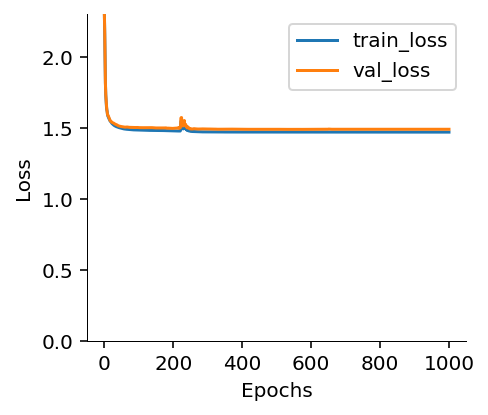

In [34]:
plot_loss(history)

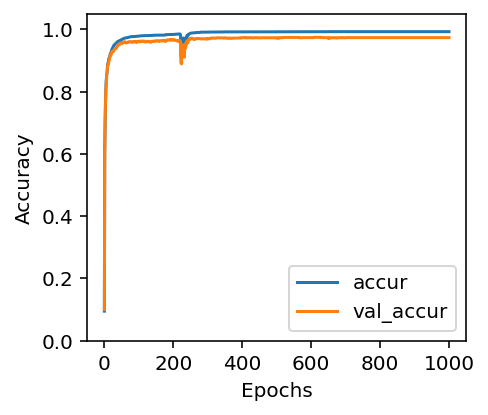

In [35]:
plot_accur(history)

In [45]:
y_pred = model(X_test)
y_pred = torch.argmax(y_pred, axis=1)
conf = confusion_matrix(y_test, y_pred.detach().numpy())
print(conf)

[[ 10 189   0   2   6   5   0   5   1   1]
 [  0 161   0  20   0   0   0   0   0  41]
 [  0 106   1   8  44   3   0  15   0   4]
 [  1 171   1  15   2   0   0   3   2   2]
 [  1  76   1  75  19   0   0  17   5   9]
 [ 14  98   4  22   1   1   0  25   7   4]
 [  0 150   5  15  10   0   0  12   2   3]
 [  4 175   0   9  12   8   0   5   0   7]
 [  0 160   2  10   8   8   0   8   1   0]
 [  1 120   0  33  20   4   0   7   1   2]]


## Preview

In the end, vanilla networks are not the most powerful architecture to process images. For that we need [convolutional networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) or CNNs.